# CFL condition for finite-difference simulations (5-point): fault-zone trapped waves
_Computational Seismology, Igel (2016)_ <br>
Exercise 4.30

_Determine numerically the stability limit of 1D and 2D implementations of the acoustic wave equation as accurately as possible by varying the stability criterion._

Acoustic wave equation (inhomogeneous):
$$\partial_t^2 p(x,t) - c^2 \Delta p(x,t) = s(x,t)$$

We can calculate a solution by iterating over the time elements:
$$p(t+dt) \approx 2p(t) - p(t-dt) + dt^2[c^2\partial^2_xp + s].$$

This time, we'll use a 5-point operator for the second derivative in $x$:
$$d^2_xp(x) \approx -\frac{1}{12}p(x+2dx) + \frac{4}{3}p(x+dx) - \frac{5}{2}p(x) + \frac{4}{3}p(x-dx) - \frac{1}{12}p(x-2dx)$$

<strong>Scenario: Sound in an air column (p. 85)</strong>
"Suppose we want to simulate acoustic wave propagation in a 10 km column (e.g. the atmosphere) and assume an air sound speed
of c = 343 m/s. We would like to hear the sound wave so it would need a dominant frequency of at least 20 Hz (at the bottom of the audible frequency range).
For the purpose of this exercise we initialize the source time function f(t) using
the first derivative of a Gaussian function (because we are aware that in 1D the
resulting signal is an integral of the source time function and we want a Gaussian
waveform)."

$$s(t) = -Af_0(t-t_0)e^{-\frac{f_0(t-t_0)^2}{(2A)^2}}$$
with dominant frequency $f_0 = 20 Hz$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("error", category=RuntimeWarning)   # convert this warning to an error (this will be used to escape the dx2p loop)

In [2]:
xmax = 500         # spatial range (km)
dx = .5            # distance between grid points
nx = int(xmax/dx)  # number of grid points
tmax = 1.5         # length of seismogram
c = 343            # wavefield velocity
ixsrc = 100        # x-coord. of source
ixrec = 200        # x-coord. of receiver

x = np.linspace(-nx*dx/2, nx*dx/2, nx)    # space

# some stf parameters
f0 = 20    # dominant frequency (Hz)
t0 = .2    # time shift
A  = 1


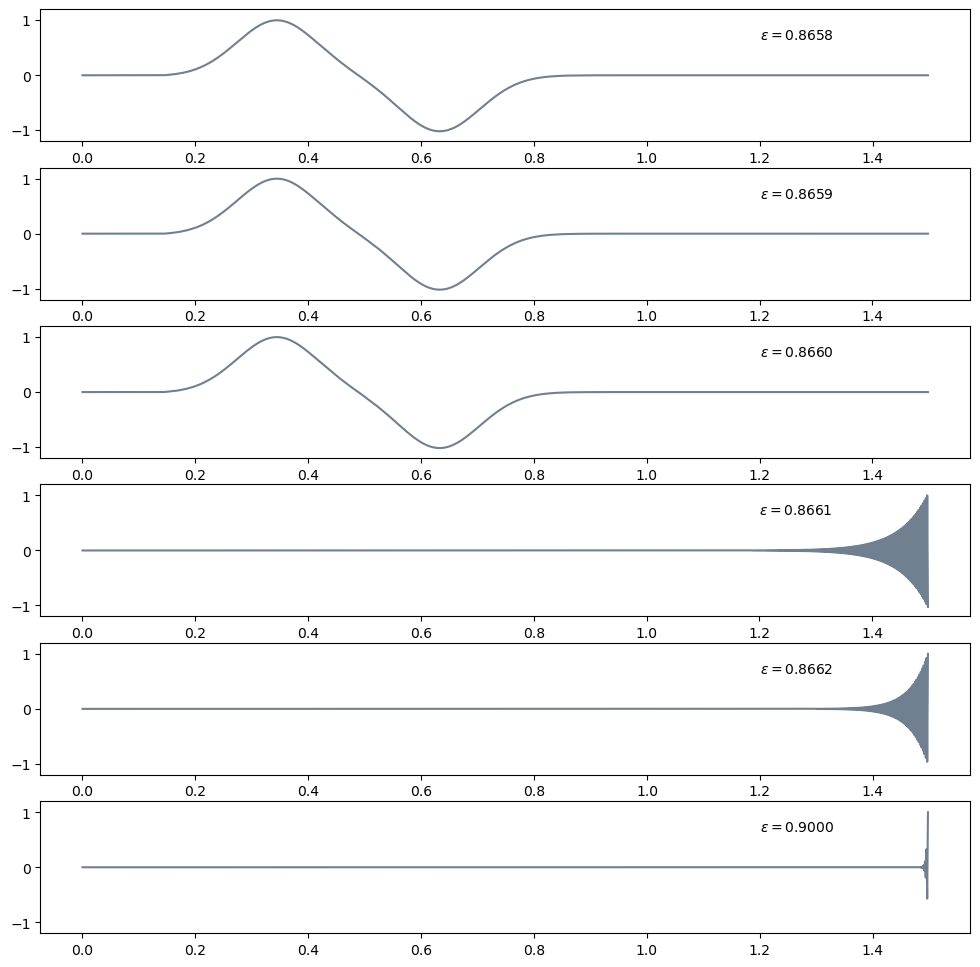

In [3]:
eps = np.arange(.8658, .8663, .0001)    # stability limits to test
eps = np.append(eps, .9)       # tacking on one more value to look at the behavior further out from the limit

quit = False
fig, axs = plt.subplots(len(eps), 1, figsize = (12, 2*len(eps)))


# iterate over each epsilon
for i in range(len(eps)):
    dt = eps[i]*dx/c               # time interval (depends on epsilon)
    nt = int(tmax/dt)              # number of time steps
    t = np.arange(0, nt*dt, dt)    # time
    p    = np.zeros(nx) 
    pold = np.zeros(nx) 
    pnew = np.zeros(nx) 
    dx2p = np.zeros(nx)
    seis = np.zeros(nt)

    # source time function
    src = -A*f0*(t-t0)*np.exp(-((t - t0)*f0 / (2*A))**2)
    
    for it in range(nt):

        # calculate partial derivatives (omit boundaries)
        for ix in range(2, nx - 2):
            try:
                dx2p[ix] = (4*(p[ix + 1] + p[ix - 1])/3 - 5*p[ix]/2 - (p[ix + 2] + p[ix - 2])/12) / (dx**2)

            # skip the calculation if dx2p explodes
            except RuntimeWarning as e:
                quit = True
                break
        
        if quit == False:
            # time extrapolation
            pnew = 2 * p - pold + c ** 2 * dt ** 2 * dx2p
        
            # add source term at ixsrc      
            pnew[ixsrc] = pnew[ixsrc] + dt**2 * src[it] / dx
            
            # remap time levels
            pold = p
            p = pnew
        
            # make seismogram
            seis[it] = p[ixrec]

        # end loop if dx2p exploded 
        else:
            print('Overflow at index', ix, 'of derivative calculation \nepsilon =', eps[i])
            break
    
    # plot seismogram
    axs[i].plot(t[:nt], seis/max(seis), 'slategray')
    axs[i].set_ylim((-1.2, 1.2))
    axs[i].text(1.2, .65, '$\\epsilon = {:.4f}$'.format(eps[i]))

### The math
We can see that the simulation breaks for $\epsilon$ > $\frac{\sqrt{3}}{2}$. Here's the analytical explanation:



<p style="width:75%">
<img src=4.30_eps_limit_math.jpg>
<span style="font-size:smaller">
</span>
</p>
